# HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded 
in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model an Ohmic environment with exponential cut-off in three ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.
* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.
* Third, we use the available OhmicBath class 

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicBath` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

## Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qutip
from qutip import (
    basis,
    expect,
    liouvillian,
    sigmax,
    sigmaz,
    spost,
    spre,
)
from qutip.solver.heom import (
    HEOMSolver,
    BosonicBath,
   FitSpectral,
    FitCorr,
    OhmicBath,
)

# Import mpmath functions for evaluation of gamma and zeta
# functions in the expression for the correlation:

from mpmath import mp

mp.dps = 15
mp.pretty = True

%matplotlib inline

## Helper functions

Let's define some helper functions for plotting the resutls

In [2]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

### System Hamiltonian

In [3]:
# Defining the system Hamiltonian
eps = 0    # Energy of the 2-level system.
Del = 0.2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [4]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

### System measurement operators

In [5]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Analytical expressions for the Ohmic bath correlation function and spectral density

Before we begin fitting, let us examine the analytic expressions for the correlation and spectral density functions and write Python equivalents. 

The correlation function is given by (see, e.g., http://www1.itp.tu-berlin.de/brandes/public_html/publications/notes.pdf for a derivation, equation 7.59, but with a factor of $\pi$ moved into the definition of the correlation function):

\begin{align}
C(t) =& \: \frac{1}{\pi}\alpha \omega_{c}^{1 - s} \beta^{- (s + 1)} \: \times \\
      & \: \Gamma(s + 1) \left[ \zeta \left(s + 1, \frac{1 + \beta \omega_c - i \omega_c t}{\beta \omega_c}\right) + \zeta \left(s + 1, \frac{1 + i \omega_c t}{\beta \omega_c}\right) \right]
\end{align}

where $\Gamma$ is the Gamma function and

\begin{equation}
\zeta(z, u) \equiv \sum_{n=0}^{\infty} \frac{1}{(n + u)^z}, \; u \neq 0, -1, -2, \ldots
\end{equation}

is the generalized Zeta function. The Ohmic case is given by $s = 1$.

The corresponding spectral density for the Ohmic case is:

\begin{equation}
J(\omega) = \omega \alpha e^{- \frac{\omega}{\omega_c}}
\end{equation}

In [6]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (
        (1 / np.pi) * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    )
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

In [7]:
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e**(-w / wc)

In [8]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """ The Ohmic bath power spectrum as a function of w
        (and the bath parameters).
    """
    return (
        w * alpha * np.e**(-abs(w) / wc) *
        ((1 / (np.e**(w * beta) - 1)) + 1) * 2
    )

### Bath and HEOM parameters

Finally, let's set the bath parameters we will work with and write down some measurement operators:

In [9]:
Q = sigmaz()
alpha = 3.25
T = 0.5
wc= 1.0
s= 1

And set the cut-off for the HEOM hierarchy:

In [10]:
# HEOM parameters:

# The max_depth defaults to 5 so that the notebook executes more
# quickly. Change it to 11 to wait longer for more accurate results.
max_depth = 5

## Building the HEOM bath by fitting the spectral density

We begin by fitting the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form (J. Chem. Phys. 111, 3365 (1999); https://doi.org/10.1063/1.479669):

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.

With the spectral density approximation $J_{\mathrm approx}(w; a, b, c)$ implemented above, we can now perform the fit and examine the results. This can be done quickly using the FitSpectral bath, which takes the target spectral density as an array and fits it to the series of **k** underdamped harmonic oscillators with the Meier-Tannor form

In [11]:
w = np.linspace(0, 15, 20000)
J = ohmic_spectral_density(w, alpha, wc)

We first initialize our FitSpectral class

In [12]:
fs=FitSpectral(T,Q,Nk=4)

To obtain a fit we simply pass our desired spectral density and range, into the get_fit method

In [13]:
fs.get_fit(J,w)

To obtain an overview of the results of the fit we may call the summary method

In [14]:
fs.summary()

Results of the fitting the Spectral density with 4 terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 6.07e-01 | 1.01e+00 |1.00e-01 
 2         |-4.44e+00 | 4.31e+00 |3.96e+00 
 3         | 7.93e+00 | 2.30e+00 |1.00e-01 
 4         | 1.07e-02 | 3.09e-01 |1.00e-01 
 
A  normalized RMSE of  2.64e-06 was obtained for the Spectral density 
 The current fit took  13.199548 seconds


By default the get_fit method, has a threshold normalized root mean squared error (NRMSE) of $5\times 10^{-6}$ and selects the number of oscillators automatically to obtain that value, one may on the other hand specify the Number of oscillators that can be done using the optional argument N, or may want a more accurate NRMSE, which can be specified with the final_rmse optional argument

or by requiring a lower NRMSE

In [15]:
fs.get_fit(J,w,final_rmse=2e-6)

In [16]:
fs.summary()

Results of the fitting the Spectral density with 5 terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 9.15e-02 | 6.03e-01 |1.00e-01 
 2         | 2.39e+00 | 1.50e+00 |1.00e-01 
 3         | 5.37e+00 | 2.28e+00 |1.15e+00 
 4         | 1.18e-03 | 1.54e-01 |1.00e-01 
 5         |-3.75e+00 | 4.31e+00 |4.17e+00 
 
A  normalized RMSE of  1.28e-06 was obtained for the Spectral density 
 The current fit took  24.697593 seconds


Alternatively one may choose the number of oscillators in the fit instead of a desired NRMSE

In [17]:
fs.get_fit(J,w,N=4)

In [18]:
fs.summary()

Results of the fitting the Spectral density with 3 terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 6.07e-01 | 1.01e+00 |1.00e-01 
 2         |-4.44e+00 | 4.31e+00 |3.96e+00 
 3         | 7.93e+00 | 2.30e+00 |1.00e-01 
 4         | 1.07e-02 | 3.09e-01 |1.00e-01 
 
A  normalized RMSE of  2.64e-06 was obtained for the Spectral density 
 The current fit took  4.815641 seconds


Let's take a closer look at our last fit by plotting the contribution of each term of the fit:

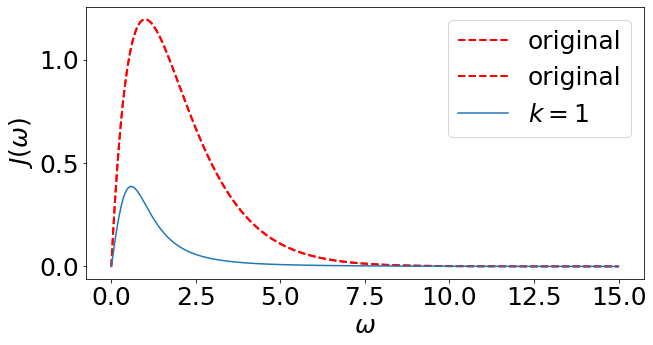

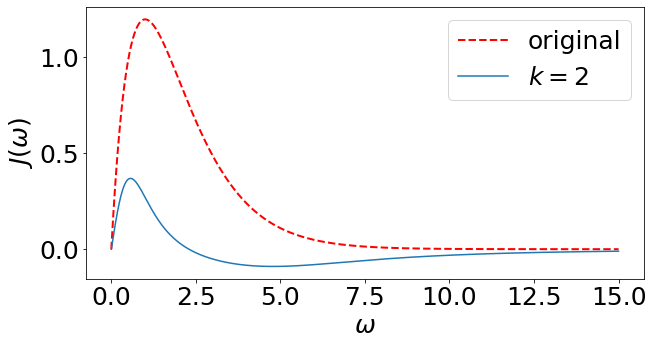

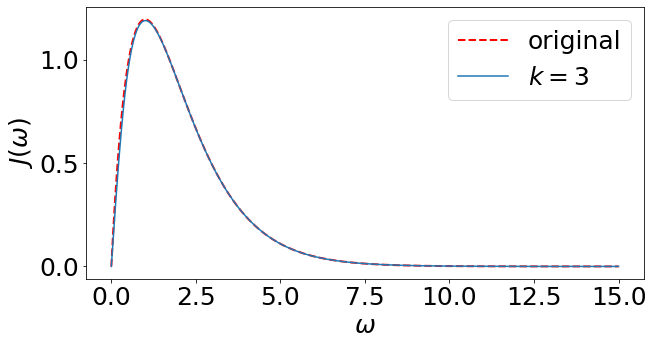

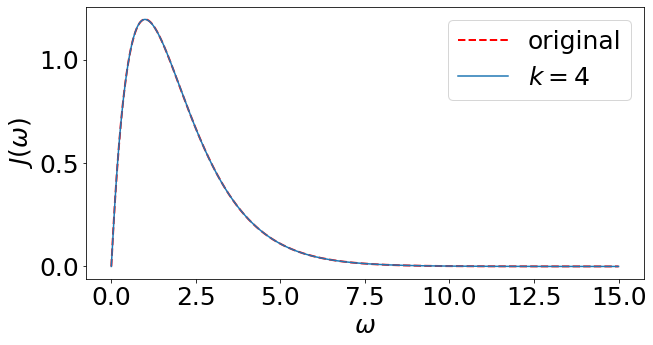

In [19]:
# Plot the components of the fit separately:
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = (10,5)
def plot_fit(func,J, w, lam, gamma, w0):
    """ Plot the individual components of a fit to the spectral density. and how they contribute to the full as an animation """
    total=0
    plt.plot(w, J, 'r--', linewidth=2, label="original")
    for i in range(len(lam)):
        component=func(w,[lam[i]],[gamma[i]],[w0[i]])
        total+=component
        plt.plot(w, J, 'r--', linewidth=2, label="original")
        plt.plot(w,total,label=rf"$k={i+1}$")
        plt.xlabel(r"$\omega$")
        plt.ylabel(r"$J(\omega)$")
        plt.legend()
        plt.pause(1)
        plt.show()
def plot_fit_components(func,J, w, lam, gamma, w0):
    """ Plot the individual components of a fit to the spectral density. and how they contribute to the full as an animation """
    total=0
    plt.plot(w, J, 'r--', linewidth=2, label="original")
    for i in range(len(lam)):
        component=func(w,[lam[i]],[gamma[i]],[w0[i]])
        plt.plot(w,component,label=rf"$k={i+1}$")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$J(\omega)$")
    plt.legend(bbox_to_anchor=(1.04, 1))
    plt.show()
lam, gamma, w0 = fs.params_spec
plot_fit(fs.spectral_density_approx,J, w, lam, gamma, w0)

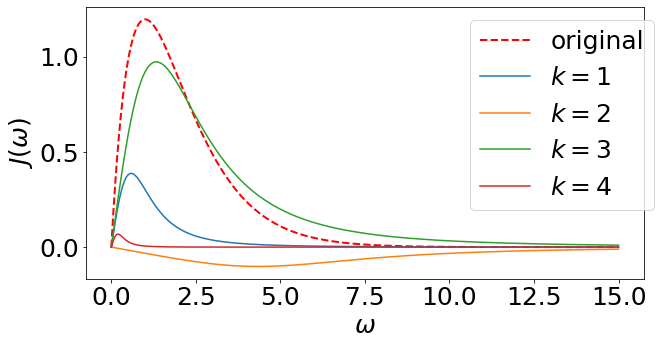

In [20]:
plot_fit_components(fs.spectral_density_approx,J, w, lam, gamma, w0)

And let's also compare the power spectrum of the fit and the analytical spectral density:

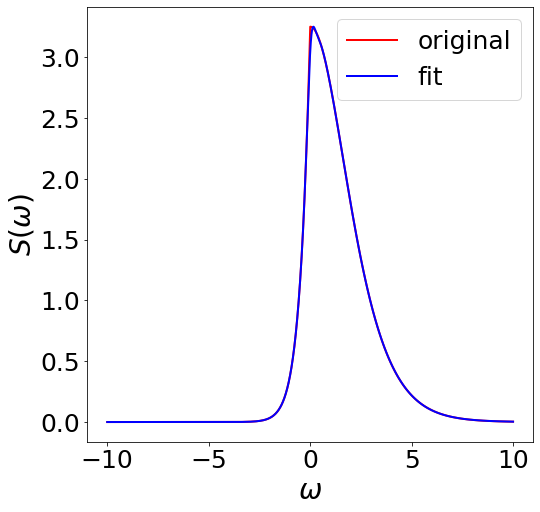

In [21]:
plt.rcParams['figure.figsize'] = (10,5)

def plot_power_spectrum(alpha, wc, beta, lam, gamma, w0, save=True):
    """ Plot the power spectrum of a fit against the actual power spectrum. """
    w = np.linspace(-10, 10, 50000)
    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = fs.spec_spectrum_approx(w)
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, s_orig, 'r', linewidth=2, label="original")
    axes.plot(w, s_fit, 'b', linewidth=2, label="fit")

    axes.set_xlabel(r'$\omega$', fontsize=28)
    axes.set_ylabel(r'$S(\omega)$', fontsize=28)
    axes.legend()

    if save:
        fig.savefig('powerspectrum.eps')


plot_power_spectrum(alpha, wc, 1/T, lam, gamma, w0, save=False)

Now that we have a good fit to the spectral density, Let us obtain its dynamics, by passing our FitSpectral bath specifications into the HEOMSolver

In [22]:
tlist = np.linspace(0, 30 * np.pi / Del, 600)
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}
Ltot = liouvillian(Hsys) + fs.terminator
HEOM_spectral_fit = HEOMSolver(Ltot, fs.Bath_spec, max_depth=4, options=options,)
result_spectral=HEOM_spectral_fit.run(rho0,tlist)

10.0%. Run time:   1.44s. Est. time left: 00:00:00:12
20.0%. Run time:   2.61s. Est. time left: 00:00:00:10
30.1%. Run time:   3.73s. Est. time left: 00:00:00:08
40.1%. Run time:   4.82s. Est. time left: 00:00:00:07
50.1%. Run time:   5.87s. Est. time left: 00:00:00:05
60.1%. Run time:   7.00s. Est. time left: 00:00:00:04
70.1%. Run time:   8.39s. Est. time left: 00:00:00:03
80.1%. Run time:  10.14s. Est. time left: 00:00:00:02
90.2%. Run time:  11.82s. Est. time left: 00:00:00:01
100.0%. Run time:  13.55s. Est. time left: 00:00:00:00
Total run time:  13.55s


Now if we want to see the systems's behaviour as we change the Number of terms in the fit, we may use this auxiliary function

In [23]:
def generate_spectrum_results(Q,beta, N, Nk, max_depth):
    """ Run the HEOM with the given bath parameters and
        and return the results of the evolution.
    """
    fs=FitSpectral(T,Q,Nk)
    fs.get_fit(J,w,N)
    Ltot = liouvillian(Hsys) + fs.terminator
    tlist = np.linspace(0, 30 * np.pi / Del, 600)

    # This problem is a little stiff, so we use  the BDF method to solve
    # the ODE ^^^
    print(f'Starting calculations for N={N} and max_depth={max_depth} ... \n ')
    HEOM_spectral_fit = HEOMSolver(
        Ltot, fs.Bath_spec, max_depth=max_depth, options=options,
    )
    results_spectral_fit = (HEOM_spectral_fit.run(rho0, tlist))
    print('\n')
    return results_spectral_fit

Below we generate results for different convergence parameters (number of terms in the fit, number of matsubara terms, and depth of the hierarchy).  For the parameter choices here, we need a relatively large depth of around '11', which can be a little slow.

In [24]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of (solver_result,
        measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        if color == 'rand':
            axes.plot(
                result.times, exp,
                c=np.random.rand(3,), label=label, **kw,
            )
        else:
            axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

Starting calculations for N=1 and max_depth=5 ... 
 
10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.1%. Run time:   0.11s. Est. time left: 00:00:00:00
40.1%. Run time:   0.13s. Est. time left: 00:00:00:00
50.1%. Run time:   0.15s. Est. time left: 00:00:00:00
60.1%. Run time:   0.16s. Est. time left: 00:00:00:00
70.1%. Run time:   0.18s. Est. time left: 00:00:00:00
80.1%. Run time:   0.19s. Est. time left: 00:00:00:00
90.2%. Run time:   0.21s. Est. time left: 00:00:00:00
100.0%. Run time:   0.23s. Est. time left: 00:00:00:00
Total run time:   0.23s


Starting calculations for N=2 and max_depth=5 ... 
 
10.0%. Run time:   0.22s. Est. time left: 00:00:00:02
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.1%. Run time:   0.42s. Est. time left: 00:00:00:00
40.1%. Run time:   0.51s. Est. time left: 00:00:00:00
50.1%. Run time:   0.60s. Est. time left: 00:00:00:00
60.1%. Run time:   0.67s. Est. time left: 00:00:00:00
70.

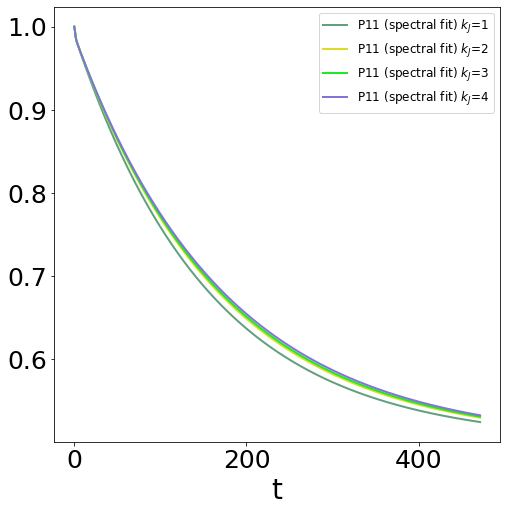

In [25]:
# Generate results for different number of lorentzians in fit:

results_spectral_fit_pk = [
    generate_spectrum_results(Q,1/T, n, Nk=1, max_depth=max_depth)
    for n in range(1,5)
]

plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (spectral fit) $k_J$={pk + 1}",
    )
    for pk, result in enumerate(results_spectral_fit_pk)
]);

Starting calculations for N=4 and max_depth=5 ... 
 
10.0%. Run time:   2.63s. Est. time left: 00:00:00:23
20.0%. Run time:   3.99s. Est. time left: 00:00:00:15
30.1%. Run time:   5.54s. Est. time left: 00:00:00:12
40.1%. Run time:   6.76s. Est. time left: 00:00:00:10
50.1%. Run time:   7.95s. Est. time left: 00:00:00:07
60.1%. Run time:   9.13s. Est. time left: 00:00:00:06
70.1%. Run time:  10.53s. Est. time left: 00:00:00:04
80.1%. Run time:  11.74s. Est. time left: 00:00:00:02
90.2%. Run time:  13.28s. Est. time left: 00:00:00:01
100.0%. Run time:  14.78s. Est. time left: 00:00:00:00
Total run time:  14.78s


Starting calculations for N=4 and max_depth=5 ... 
 
10.0%. Run time:   4.37s. Est. time left: 00:00:00:39
20.0%. Run time:   7.30s. Est. time left: 00:00:00:29
30.1%. Run time:  10.56s. Est. time left: 00:00:00:24
40.1%. Run time:  13.65s. Est. time left: 00:00:00:20
50.1%. Run time:  16.66s. Est. time left: 00:00:00:16
60.1%. Run time:  19.72s. Est. time left: 00:00:00:13
70.

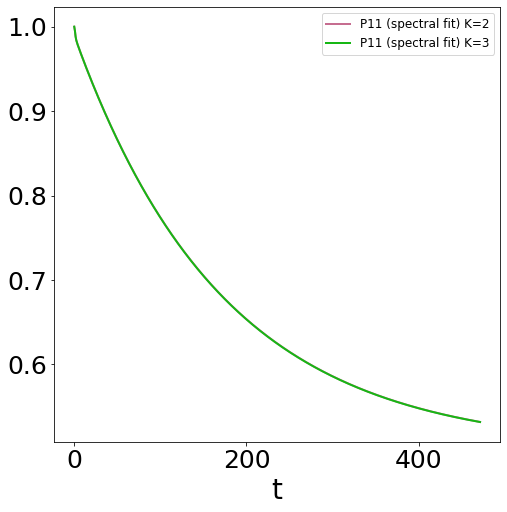

In [26]:
# generate results for different number of Matsubara terms per Lorentzian
# for max number of Lorentzians:

Nk_list = range(2, 4)
results_spectral_fit_nk = [
    generate_spectrum_results(Q,1/T, 4, Nk=Nk, max_depth=max_depth)
    for Nk in Nk_list
]

plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (spectral fit) K={nk}",
    )
    for nk, result in zip(Nk_list, results_spectral_fit_nk)
]);

Starting calculations for N=4 and max_depth=2 ... 
 
10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.1%. Run time:   0.11s. Est. time left: 00:00:00:00
40.1%. Run time:   0.14s. Est. time left: 00:00:00:00
50.1%. Run time:   0.16s. Est. time left: 00:00:00:00
60.1%. Run time:   0.23s. Est. time left: 00:00:00:00
70.1%. Run time:   0.24s. Est. time left: 00:00:00:00
80.1%. Run time:   0.26s. Est. time left: 00:00:00:00
90.2%. Run time:   0.28s. Est. time left: 00:00:00:00
100.0%. Run time:   0.29s. Est. time left: 00:00:00:00
Total run time:   0.29s


Starting calculations for N=4 and max_depth=3 ... 
 
10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.23s. Est. time left: 00:00:00:00
30.1%. Run time:   0.28s. Est. time left: 00:00:00:00
40.1%. Run time:   0.33s. Est. time left: 00:00:00:00
50.1%. Run time:   0.38s. Est. time left: 00:00:00:00
60.1%. Run time:   0.43s. Est. time left: 00:00:00:00
70.

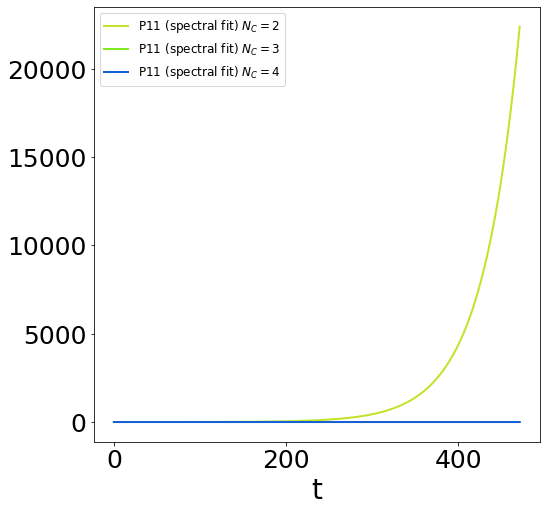

In [27]:
# Generate results for different depths:

Nc_list = range(2, max_depth)
results_spectral_fit_nc = [
    generate_spectrum_results(Q,1/T, 4, Nk=1, max_depth=Nc)
    for Nc in Nc_list
]

plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (spectral fit) $N_C={nc}$",
    )
    for nc, result in zip(Nc_list, results_spectral_fit_nc)
]);

We now combine the fitting and correlation function data into one large plot.

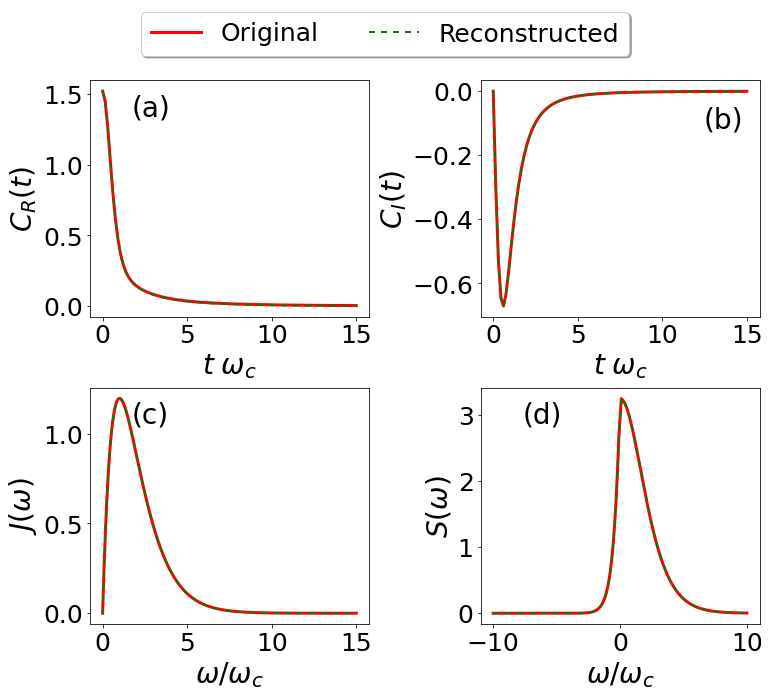

In [28]:
t = np.linspace(0, 15, 100)
C =ohmic_correlation(t, alpha=alpha, wc=wc, beta=1/T)
w2 = np.concatenate(
    [np.linspace(-10, -0.1, 5000),
     np.linspace(0.1, 10, 5000)],
)
S=ohmic_power_spectrum(w2,alpha=alpha,beta=1/T,wc=wc)


fs.fit_plots(w,J,t, C,w2,S);

## Building the HEOM bath by fitting the correlation function

Having successfully fitted the spectral density and used the result to calculate the Matsubara expansion and terminator for the HEOM bosonic bath, we now proceed to the second case of fitting the correlation function itself instead.

Here we fit the real and imaginary parts separately, using the following ansatz

$$C_R^F(t) = \sum_{i=1}^{k_R} c_R^ie^{-\gamma_R^i t}\cos(\omega_R^i t)$$

$$C_I^F(t) = \sum_{i=1}^{k_I} c_I^ie^{-\gamma_I^i t}\sin(\omega_I^i t)$$

Analogously to the spectral density case, one may use the FitCorr class

In [29]:
fc=FitCorr(Q)

In [30]:
t = np.linspace(0, 25, 1500)
C = ohmic_correlation(t, alpha=alpha, wc=wc, beta=1/T)

In [31]:
fc.fit_correlation(t,C,Ni=3,Nr=3)

In [32]:
fc.summary()

Fit correlation class instance: 
 

Results of the fitting the Real Part with 3 terms:                |	 Results of the fitting the Imaginary Part with 3 terms:             
                                                                  |                                                                      
 Parameters|   lam    |  gamma   |   w0                           | 	 Parameters|   lam    |  gamma   |   w0                             
 1         | 2.23e+00 |-2.20e+00 |2.45e-05                        |	 1         |-3.32e+00 |-9.96e-01 |1.66e-01                           
 2         |-9.25e-01 |-4.96e+00 |3.91e+00                        | 	 2         |-8.59e-01 |-1.09e+00 |1.37e+00                          
 3         | 2.18e-01 |-3.36e-01 |1.50e-18                        | 	 3         |-3.07e-01 |-1.19e+00 |2.70e+00                          
                                                                  |                                                                     

In [33]:
fc.fit_correlation(t,C,final_rmse=1e-4)

In [34]:
fc.summary()

Fit correlation class instance: 
 

Results of the fitting the Real Part with 3 terms:                |	 Results of the fitting the Imaginary Part with 5 terms:             
                                                                  |                                                                      
 Parameters|   lam    |  gamma   |   w0                           | 	 Parameters|   lam    |  gamma   |   w0                             
 1         | 2.23e+00 |-2.20e+00 |2.45e-05                        |	 1         |-1.32e+00 |-1.13e+00 |4.34e-36                           
 2         |-9.25e-01 |-4.96e+00 |3.91e+00                        | 	 2         |-3.70e-01 |-9.44e-01 |2.11e+00                          
 3         | 2.18e-01 |-3.36e-01 |1.50e-18                        | 	 3         |-1.51e-01 |-1.03e+00 |3.32e+00                          
                                                                  | 	 4         |-2.48e+00 |-8.63e-01 |1.37e-01                         

Now we construct the `BosonicBath` co-efficients and frequencies from the fit to the correlation function:

/home/mcditoos/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:1545: RuntimeWarning: divide by zero encountered in divide
  (((1 / (np.e**(w * beta) - 1)) + 1) * 2)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


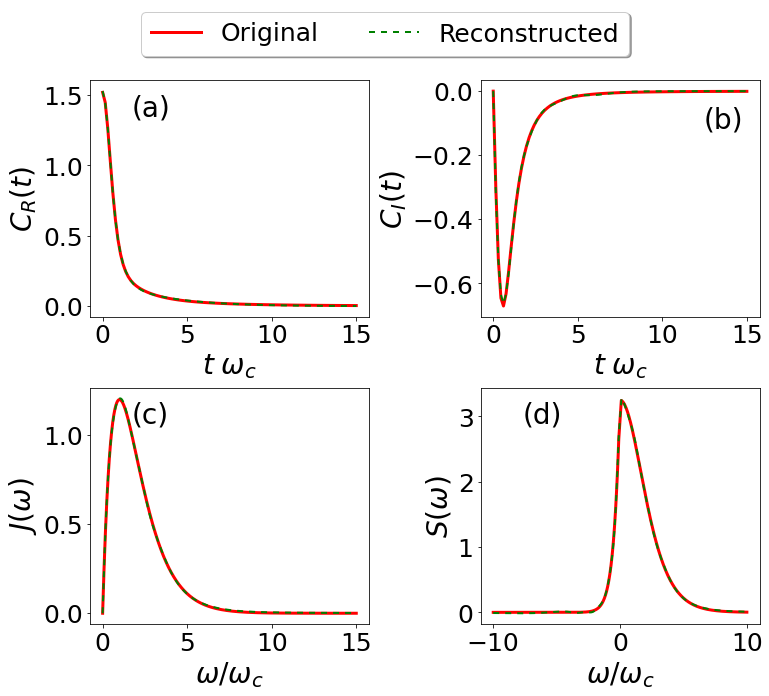

In [35]:
t = np.linspace(0, 15, 100)
C = ohmic_correlation(t, alpha=alpha, wc=wc, beta=1/T)
fc.fit_plots(w, J, t, C, w2, S,beta=1/T)

In [36]:
def generate_corr_results(N, max_depth):
    tlist = np.linspace(0, 30 * np.pi / Del, 600)
    t = np.linspace(0, 15, 100)
    C = ohmic_correlation(t, alpha=alpha, wc=wc, beta=1/T)
    fc.fit_correlation(t,C,Ni=N,Nr=N)
    HEOM_corr_fit = HEOMSolver(
        Hsys, fc.Bath_corr, max_depth=max_depth, options=options,
    )

    results_corr_fit = (HEOM_corr_fit.run(rho0, tlist))

    return results_corr_fit


# Generate results for different number of lorentzians in fit:
results_corr_fit_pk = [
    print(f"{i + 1}") or generate_corr_results(i, max_depth=max_depth,
    )
    for i in range(1,4)
]

2
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.1%. Run time:   0.06s. Est. time left: 00:00:00:00
50.1%. Run time:   0.08s. Est. time left: 00:00:00:00
60.1%. Run time:   0.09s. Est. time left: 00:00:00:00
70.1%. Run time:   0.10s. Est. time left: 00:00:00:00
80.1%. Run time:   0.12s. Est. time left: 00:00:00:00
90.2%. Run time:   0.13s. Est. time left: 00:00:00:00
100.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.15s
3
10.0%. Run time:   0.48s. Est. time left: 00:00:00:04
20.0%. Run time:   0.72s. Est. time left: 00:00:00:02
30.1%. Run time:   0.95s. Est. time left: 00:00:00:02
40.1%. Run time:   1.17s. Est. time left: 00:00:00:01
50.1%. Run time:   1.38s. Est. time left: 00:00:00:01
60.1%. Run time:   1.62s. Est. time left: 00:00:00:01
70.1%. Run time:   1.88s. Est. time left: 00:00:00:00
80.1%. Run time:   2.13s. Est. time left: 00:00:00:00

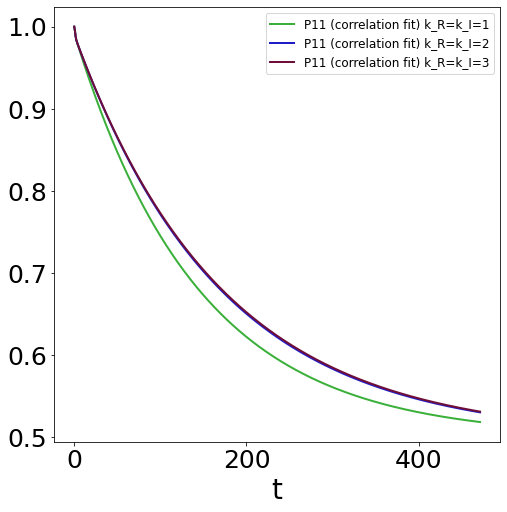

In [37]:
plot_result_expectations([
    (
        result, P11p, 'rand',
        f"P11 (correlation fit) k_R=k_I={pk + 1}",
    )
    for pk, result in enumerate(results_corr_fit_pk)
]);

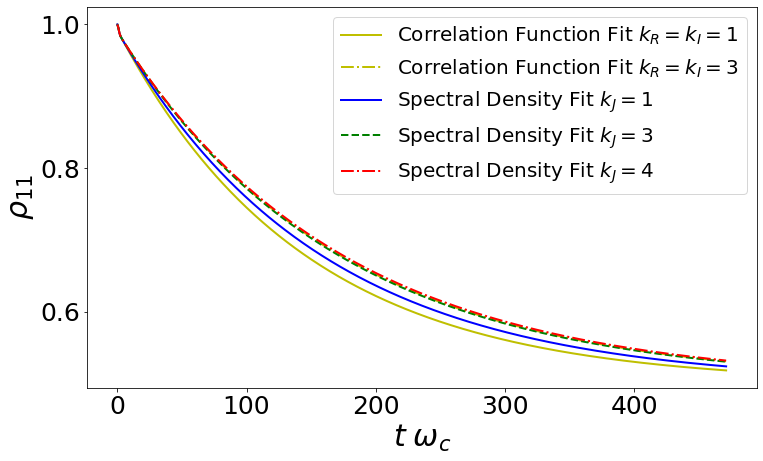

In [38]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations([
    (
        results_corr_fit_pk[0], P11p,
        'y', "Correlation Function Fit $k_R=k_I=1$",
    ),
    (
        results_corr_fit_pk[2], P11p,
        'y-.', "Correlation Function Fit $k_R=k_I=3$",
    ),
    (results_spectral_fit_pk[0], P11p, 'b', "Spectral Density Fit $k_J=1$"),
    (results_spectral_fit_pk[2], P11p, 'g--', "Spectral Density Fit $k_J=3$"),
    (results_spectral_fit_pk[3], P11p, 'r-.', "Spectral Density Fit $k_J=4$"),
], axes=axes)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r'$\rho_{11}$', fontsize=30)
axes.set_xlabel(r'$t\;\omega_c$', fontsize=30)
axes.legend(loc=0, fontsize=20);

# Using the Ohmic Bath class

While the two classes above are designed for general fits of either correlation functions or spectral densities, as the ohmic spectrum is popular in the modeling of open quantum systems, it has its own dedicated class, the results above can be reproduced shortly by using the OhmicBath class. By default the method fits using the  spectral density, however it can use the correlation function if method is specified

In [39]:
obs=OhmicBath(T,Q,alpha,wc,s,rmse=1e-5,method='spectral')

In [40]:
obs.summary()

Results of the fitting the Spectral density with 4 terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 6.07e-01 | 1.01e+00 |1.00e-01 
 2         |-4.44e+00 | 4.31e+00 |3.96e+00 
 3         | 7.93e+00 | 2.30e+00 |1.00e-01 
 4         | 1.07e-02 | 3.09e-01 |1.00e-01 
 
A  normalized RMSE of  2.64e-06 was obtained for the Spectral density 
 The current fit took  28.250522 seconds


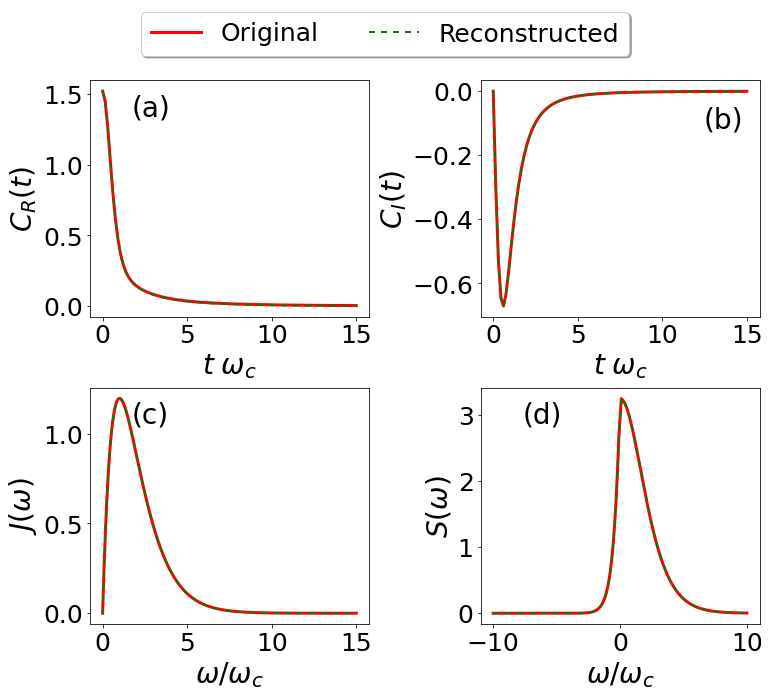

In [41]:
obs.fit.fit_plots(w,J,t, C,w2,S);

In [52]:
obc=OhmicBath(T,Q,alpha,wc,s,rmse=1e-4,method='correlation')

In [53]:
obc.summary()

Fit correlation class instance: 
 

Results of the fitting the Real Part with 5 terms:                |	 Results of the fitting the Imaginary Part with 4 terms:             
                                                                  |                                                                      
 Parameters|   lam    |  gamma   |   w0                           | 	 Parameters|   lam    |  gamma   |   w0                             
 1         | 2.12e+00 |-2.51e+00 |9.30e-01                        |	 1         |-3.36e+00 |-2.20e+00 |9.56e-01                           
 2         | 3.60e-02 |-1.40e-01 |5.02e-08                        | 	 2         |-3.36e+00 |-4.32e-01 |4.61e-03                          
 3         | 6.41e+00 |-7.66e-01 |7.27e-05                        | 	 3         | 4.27e-01 |-4.29e+00 |4.30e+00                          
 4         |-5.80e+00 |-7.52e-01 |9.31e-02                        | 	 4         |-3.36e+00 |-1.23e+00 |2.01e-01                         

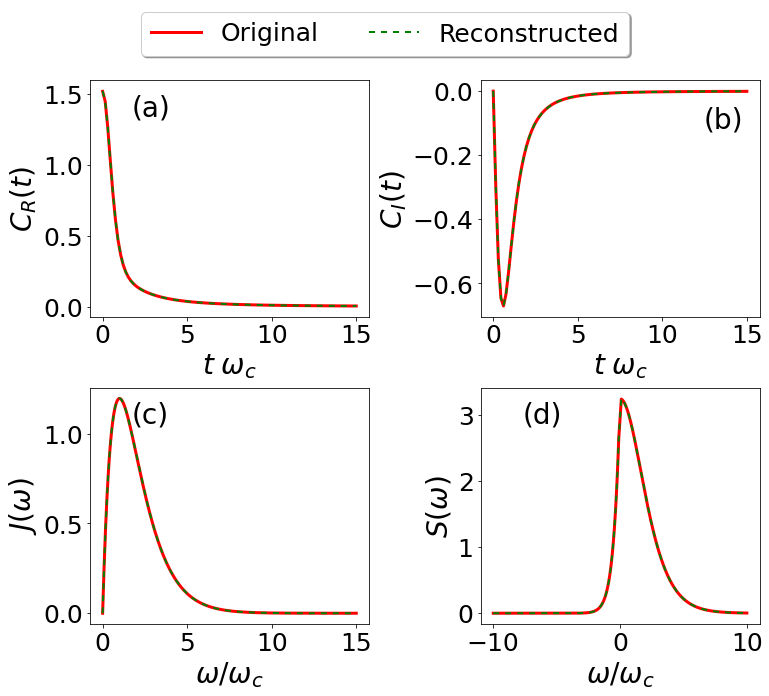

In [54]:
obc.fit.fit_plots(w, J, t, C, w2, S,beta=1/T)

In [55]:
tlist = np.linspace(0, 30 * np.pi / Del, 600)

HEOM_ohmic_corr_fit = HEOMSolver(Hsys, obc.bath, max_depth=5, options=options,)
Ltot = liouvillian(Hsys) + fs.terminator
HEOM_ohmic_spectral_fit = HEOMSolver(Hsys, obs.bath, max_depth=5, options=options,)

#results__ohmic_corr_fit = (HEOM_ohmic_corr_fit.run(rho0, tlist))
results_ohmic_spectral_fit = (HEOM_ohmic_spectral_fit.run(rho0, tlist))

10.0%. Run time:   9.32s. Est. time left: 00:00:01:23
20.0%. Run time:  14.89s. Est. time left: 00:00:00:59
30.1%. Run time:  20.69s. Est. time left: 00:00:00:48
40.1%. Run time:  28.31s. Est. time left: 00:00:00:42
50.1%. Run time:  37.21s. Est. time left: 00:00:00:37
60.1%. Run time:  44.90s. Est. time left: 00:00:00:29
70.1%. Run time:  52.61s. Est. time left: 00:00:00:22
80.1%. Run time:  60.75s. Est. time left: 00:00:00:15
90.2%. Run time:  68.44s. Est. time left: 00:00:00:07
100.0%. Run time:  76.71s. Est. time left: 00:00:00:00
Total run time:  76.71s


In [ ]:
results_ohmic_corr_fit = (HEOM_ohmic_corr_fit.run(rho0, tlist))


10.0%. Run time:  30.90s. Est. time left: 00:00:04:37
20.0%. Run time:  58.34s. Est. time left: 00:00:03:52
30.1%. Run time:  84.19s. Est. time left: 00:00:03:15
40.1%. Run time: 112.52s. Est. time left: 00:00:02:48
50.1%. Run time: 139.78s. Est. time left: 00:00:02:19
60.1%. Run time: 167.44s. Est. time left: 00:00:01:51
70.1%. Run time: 194.66s. Est. time left: 00:00:01:22
80.1%. Run time: 229.82s. Est. time left: 00:00:00:56
90.2%. Run time: 260.57s. Est. time left: 00:00:00:28


In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations([
 #   (
 #       results_corr_fit_pk[0], P11p,
 #       'y', "Correlation Function Fit $k_R=k_I=1$",
 #   ),
    (
        results_corr_fit_pk[2], P11p,
        'y-.', "Correlation Function Fit $k_R=k_I=3$",
    ),
    (results_spectral_fit_pk[0], P11p, 'b', "Spectral Density Fit $k_J=1$"),
    (results_spectral_fit_pk[2], P11p, 'g--', "Spectral Density Fit $k_J=3$"),
    (results_spectral_fit_pk[3], P11p, 'r-.', "Spectral Density Fit $k_J=4$"),
    (results_ohmic_spectral_fit, P11p, 'g-.', "Spectral Density Fit Ohmic Bath"),
    (results_ohmic_corr_fit, P11p, 'k-.', "Correlation Fit Ohmic Bath")

], axes=axes)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r'$\rho_{11}$', fontsize=30)
axes.set_xlabel(r'$t\;\omega_c$', fontsize=30)
axes.legend(loc=0, fontsize=20);

## About

In [ ]:
qutip.about()

## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [ ]:
assert np.allclose(
    expect(P11p, results_spectral_fit_pk[2].states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)